In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
plt.ion()
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
import xgboost as xgb

from metric_utils import *

import warnings
warnings.filterwarnings("ignore")

In [61]:
# ar data with flares
data_ar = pd.read_csv("AR_flare_ml_23_24.csv")

# evolution data
data_ar_evol = pd.read_csv("AR_flare_ml_23_24_evol.csv")
# replace nans with 0's with pre-flare feature
data_ar_evol["pre_flare"].replace(np.nan, 0, inplace=True)

# replicate rows for rows that have flares C+ > 1
new_rows = []
for i in range(len(data_ar_evol)):
    df = data_ar_evol.iloc[i]
    no_flares = df["C+"].astype(int)
    if no_flares > 1:
        nr = [df]*(no_flares-1)
        for n in nr:
            new_rows.append(n)

data_ar_evol = data_ar_evol.append(new_rows, ignore_index=True)
data_ar_evol["C+"] = data_ar_evol["C+"].map(lambda x: 1 if x>0 else 0)
data_ar_evol.drop(columns=["M+", "X+"], inplace=True)

data_ar_evol.sort_values(by="AR issue_date", inplace=True)

In [62]:
data_ar_evol.head()

,AR issue_date,noaa_ar,Carrington_long,AREA,McIntosh,Longitude_extent,Latitude,Longitude,No_sunspots,MAGTYPE,LOCATION,C,M,X,C+,pre_area,pre_mcint,pre_mag,pre_flare
0,1996-08-01 00:30,7981,258,410,ESO,12,-9,-22,24.0,BETA-GAMMA,S09E22,0.0,0.0,0.0,0,NaN,NaN,NaN,0.0
1,1996-08-02 00:30,7981,257,300,ESI,12,-9,-9,22.0,BETA-GAMMA,S09E09,0.0,0.0,0.0,0,410.0,ESO,BETA-GAMMA,0.0
2,1996-08-03 00:30,7981,258,320,ESO,12,-9,5,24.0,BETA-GAMMA,S09W05,0.0,0.0,0.0,0,300.0,ESI,BETA-GAMMA,0.0
3,1996-08-04 00:30,7981,259,290,ESO,11,-9,19,20.0,BETA-GAMMA,S09W19,0.0,0.0,0.0,0,320.0,ESO,BETA-GAMMA,0.0
4,1996-08-05 00:30,7981,260,220,CSO,10,-9,33,19.0,BETA-GAMMA,S09W33,0.0,0.0,0.0,0,290.0,ESO,BETA-GAMMA,0.0


## Feature scaling and encoding 

In [85]:
cols = ["AR issue_date", "Longitude_extent", "AREA", "McIntosh", "No_sunspots", "MAGTYPE", "C+"]
data_ml = data_ar_evol[cols]

In [86]:
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
data_ml["MAGTYPE"] = le1.fit_transform(data_ml["MAGTYPE"])
data_ml["McIntosh"] = le2.fit_transform(data_ml["McIntosh"])

scaled_categorical = preprocessing.MinMaxScaler().fit_transform(data_ml[["MAGTYPE", "McIntosh"]])
data_ml = pd.concat([data_ml, pd.DataFrame(scaled_categorical, columns=["MAGTYPE_enc", "McIntosh_enc"])], axis=1)


In [87]:
# scale the numerical data 
scaled_numerical = preprocessing.MinMaxScaler().fit_transform(data_ml[["AREA", "Longitude_extent", "No_sunspots"]])#.apply(np.log1p).values)
data_ml = pd.concat([data_ml, pd.DataFrame(scaled_numerical, columns=["AREA_scaled", "Longitude_scaled", "NoSunspots_scaled"])], axis=1)
data_ml.drop(columns=["AREA", "Longitude_extent", "No_sunspots"], inplace=True)



In [88]:
data_ml.head()

,AR issue_date,McIntosh,MAGTYPE,C+,MAGTYPE_enc,McIntosh_enc,AREA_scaled,Longitude_scaled,NoSunspots_scaled
0,1996-08-01 00:30,42,3,0,0.5,0.677419,0.149091,0.324324,0.195122
1,1996-08-02 00:30,41,3,0,0.5,0.661290,0.109091,0.324324,0.178862
2,1996-08-03 00:30,42,3,0,0.5,0.677419,0.116364,0.324324,0.195122
3,1996-08-04 00:30,42,3,0,0.5,0.677419,0.105455,0.297297,0.162602
4,1996-08-05 00:30,13,3,0,0.5,0.209677,0.080000,0.270270,0.154472


In [89]:
train_ar = data_ml[~(data_ml["AR issue_date"]>="2016-01-01")&(data_ml["AR issue_date"]<="2017-12-31")].drop(columns=["AR issue_date"])
test_ar = data_ml[(data_ml["AR issue_date"]>="2016-01-01")&(data_ml["AR issue_date"]<="2017-12-31")].drop(columns=["AR issue_date"])


In [90]:
X_cols = ["McIntosh_enc", "MAGTYPE_enc", "AREA_scaled", 
          "Longitude_scaled", "NoSunspots_scaled"]

# X_cols = ["McIntosh", "MAGTYPE"]

Y_col = ["C+"]

X_train, X_test = train_ar[X_cols], test_ar[X_cols]
Y_train, Y_test = train_ar[Y_col].values, test_ar[Y_col].values

In [91]:
#mdl = SVC(probability=True, class_weight="balanced")
mdl = GradientBoostingClassifier()

In [92]:
mdl.fit(X_train, Y_train)

GradientBoostingClassifier()

In [93]:
pred = mdl.predict(X_test)
pred_prob = mdl.predict_proba(X_test)[:, 1]

In [94]:
bss = calculate_bss(Y_test, pred_prob)
tss = calculate_tss(Y_test, pred)

print("BSS is {:.02f} and TSS is {:.02f}".format(bss, tss))

BSS is 0.59 and TSS is 0.57


(<AxesSubplot:title={'center':'Reliability Curve'}, ylabel='Fraction of positives'>,
 <AxesSubplot:xlabel='Mean predicted value', ylabel='# events'>)

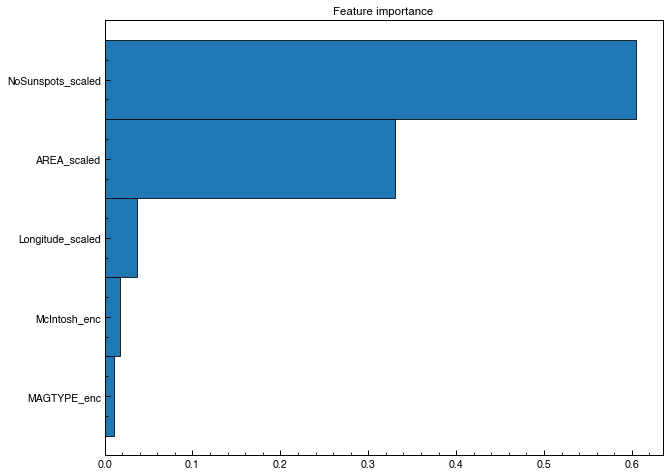

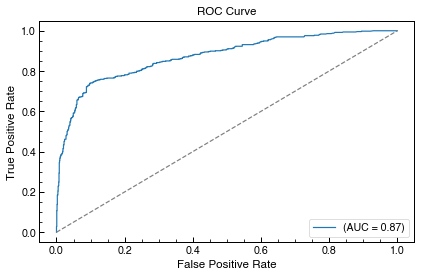

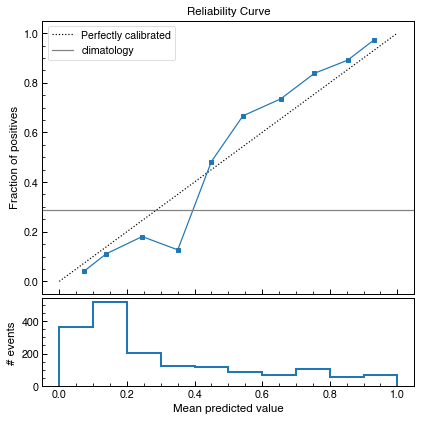

In [95]:
plot_feature_importance(mdl, X_train)
plot_roc_curve(Y_test, pred_prob)
plot_reliability_curve(Y_test, pred_prob, n_bins=10)

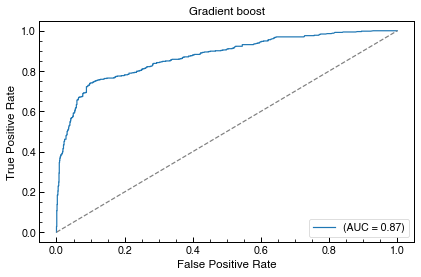

In [97]:
ax_roc = plot_roc_curve(Y_test, pred_prob)
ax_roc.set_title("Gradient boost")
plt.savefig("./overview_plots/gradient_boost.png", dpi=300, facecolor="w", bbox_inches="tight")

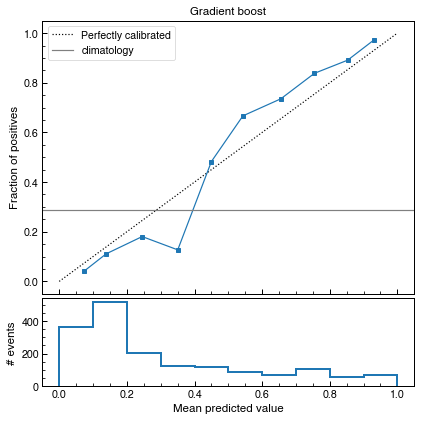

In [98]:
ax_rel = plot_reliability_curve(Y_test, pred_prob, n_bins=10)
ax_rel[0].set_title("Gradient boost")
plt.savefig("./overview_plots/gradient_boost_rel.png", dpi=300, facecolor="w", bbox_inches="tight")

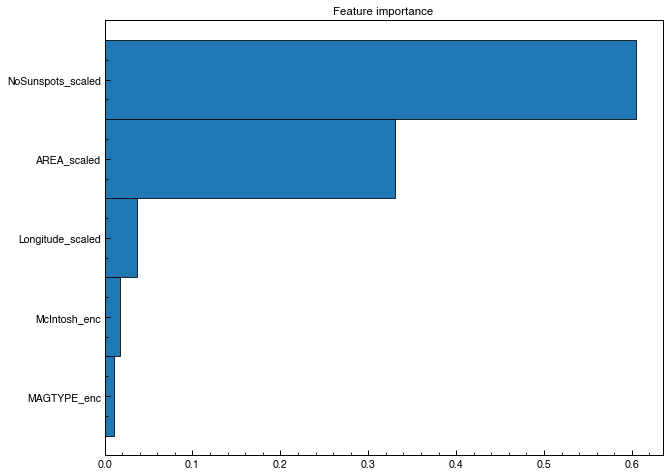

In [99]:
plot_feature_importance(mdl, X_train)
plt.savefig("./overview_plots/gradient_boost_features.png", dpi=300, facecolor="w")

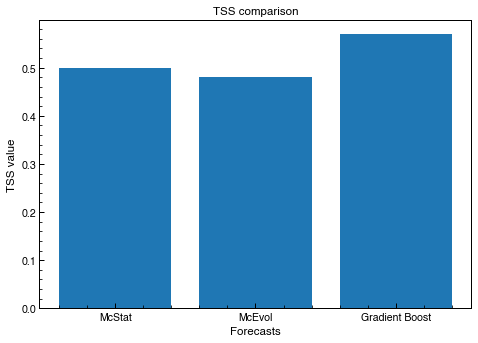

In [102]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['McStat', 'McEvol', 'Gradient Boost']
students = [0.5, 0.48, 0.57]
ax.bar(langs,students)
ax.set_xlabel("Forecasts")
ax.set_ylabel("TSS value")
ax.set_title("TSS comparison")
plt.savefig("./overview_plots/tss_compare.png", dpi=300, facecolor="w")

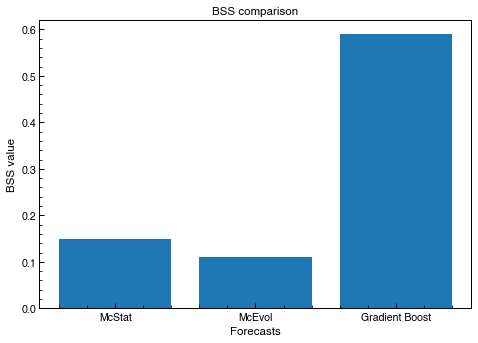

In [103]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['McStat', 'McEvol', 'Gradient Boost']
students = [0.15, 0.11, 0.59]
ax.bar(langs,students)
ax.set_xlabel("Forecasts")
ax.set_ylabel("BSS value")
ax.set_title("BSS comparison")
plt.savefig("./overview_plots/bss_compare.png", dpi=300, facecolor="w")